# Exploring Wavelet Analysis Tools in Python

This is brought about by the deprecation of `scipy.signal.cwt` in `scipy` v1.12 and its removal in v1.15. The `scipy` team recommends the use of `pywavelets`, so can we reproduce `scipy` wavelet analysis with `pywavelets` and other tools?

See:
- [`scipy.signal.cwt` documentation](https://docs.scipy.org/doc/scipy-1.12.0/reference/generated/scipy.signal.cwt.html)
- [`pywavelets` documentation](https://pywavelets.readthedocs.io/en/latest/)

## Imports

We will need
- `numpy` for basic numerical operations
- `matplotlib.pyplot` for plotting
- `scipy.signal`<1.15 for the scipy implementation
- `pywt` for the pywavelets implementation

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pywt

## Set Up Signals

Let's look at two different kinds of signals:
1. a "chirp" signal, where the frequency changes with time
2. a multimodal sinusoid, where each sine component has equal amplitude

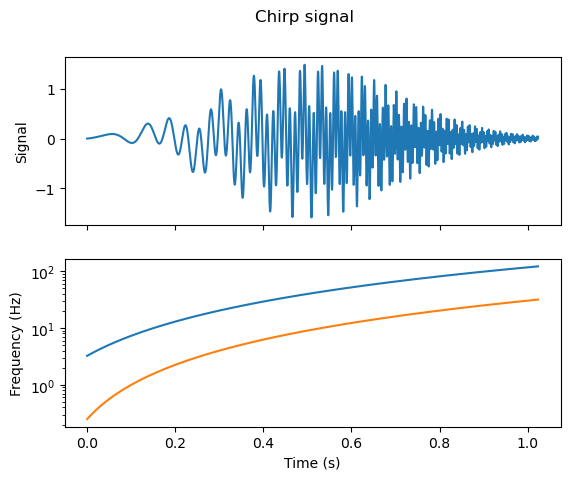

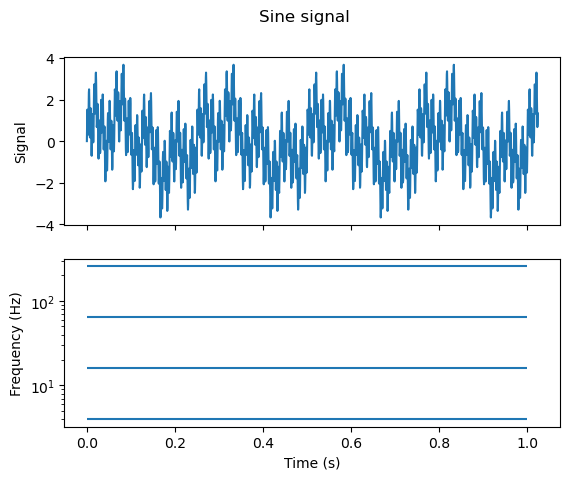

In [2]:
def gaussian(x, x0, sigma):
    return np.exp(-((x - x0)/sigma)**2 / 2)


def make_chirp(t, t0, a):
    frequency = (a * (t + t0)) ** 2
    chirp = np.sin(2*np.pi*frequency*t)
    return chirp, frequency
    

def chirps(time):
    chirp1, frequency1 = make_chirp(time, 0.2, 9)
    chirp2, frequency2 = make_chirp(time, 0.1, 5)
    chirp = chirp1 + 0.6*chirp2
    chirp *= gaussian(time, 0.5, 0.2)
    return chirp, frequency1, frequency2


def sines(time, periods):
    y = np.sum([np.sin(2*np.pi*time/p) for p in periods], axis=0)
    return y

    
# generate chirp signal
time, dt = np.linspace(0, 1.0235, 2048, retstep=True)
chirp_signal, frequency1, frequency2 = chirps(time)

# plot signal
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(time, chirp_signal)
axs[1].plot(time, frequency1)
axs[1].plot(time, frequency2)
axs[1].set_yscale("log")
axs[1].set_xlabel("Time (s)")
axs[0].set_ylabel("Signal")
axs[1].set_ylabel("Frequency (Hz)")
plt.suptitle("Chirp signal")
plt.show()


# generate sines signal
periods = np.array([1/256, 1/64, 1/16, 1/4])
sine_signal = sines(time, periods)

# plot signal
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(time, sine_signal)
axs[1].hlines(1/periods, xmin=0, xmax=1)
axs[1].set_yscale("log")
axs[1].set_xlabel("Time (s)")
axs[0].set_ylabel("Signal")
axs[1].set_ylabel("Frequency (Hz)")
plt.suptitle("Sine signal")
plt.show()

## Perform a Continuous Wavelet Transform on the Signals

Using two implementations on two signals will give us four CWTs total.

/var/folders/s5/mzsl79_56tlczq9y98qqm33w0005sm/T/ipykernel_94151/1327584830.py:16: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  cwtmatr = signal.cwt(y_signal, wavelet, widths, w=w)


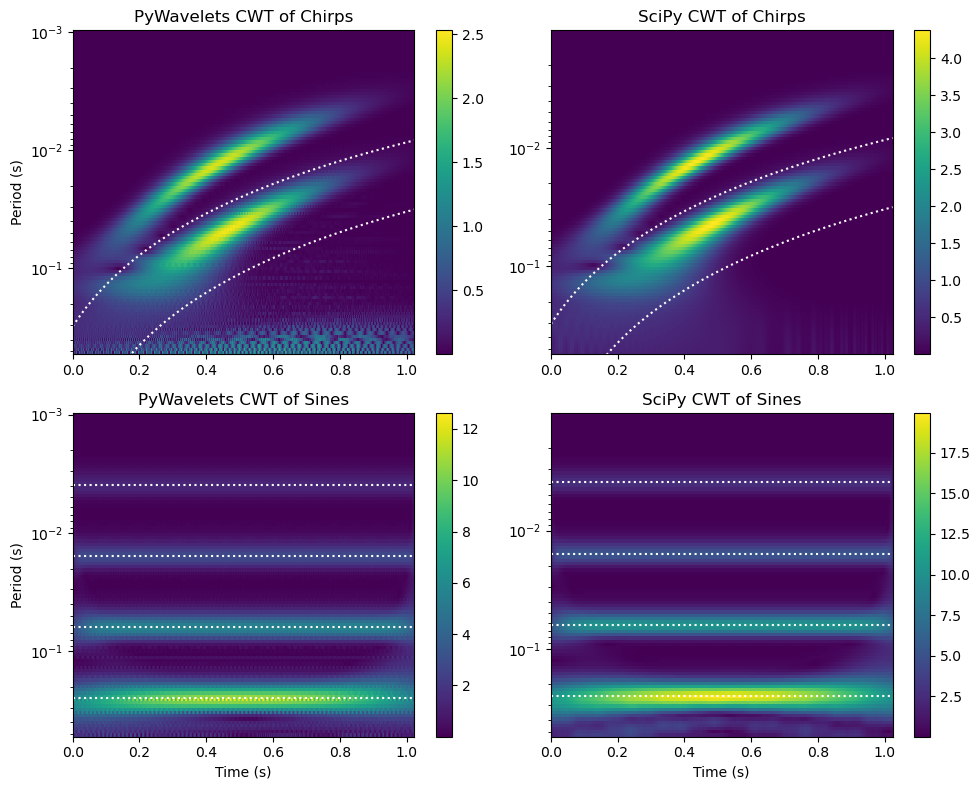

In [3]:
def cwt_pywt(time, y_signal, widths, wavelet="cmor1.5-1.0"):
    sampling_period = np.diff(time).mean()
    cwtmatr, freqs = pywt.cwt(y_signal, widths, wavelet, sampling_period=sampling_period)
    cwtmatr = np.abs(cwtmatr)

    # shift freqs to define the edges of the cells
    log_freqs = np.log10(freqs)
    delta_freq = np.diff(log_freqs).mean()
    log_freqs = np.append(log_freqs[0]-delta_freq/2, log_freqs+delta_freq/2)
    freqs = 10**log_freqs
    return cwtmatr, 1/freqs
    

def cwt_scipy(time, y_signal, widths, w=6, wavelet=signal.morlet2):
    sampling_period = np.diff(time).mean()
    cwtmatr = signal.cwt(y_signal, wavelet, widths, w=w)
    cwtmatr = np.abs(cwtmatr)#**2 / widths[:, np.newaxis]
    
    freqs = w / (2*np.pi*sampling_period*widths)
    # shift freqs to define the edges of the cells
    log_freqs = np.log10(freqs)
    delta_freq = np.diff(log_freqs).mean()
    log_freqs = np.append(log_freqs[0]-delta_freq/2, log_freqs+delta_freq/2)
    freqs = 10**log_freqs
    return cwtmatr, 1/freqs


# logarithmic scale for scales, as suggested by Torrence & Compo:
widths = np.geomspace(2, 1024, num=100)

chirp_power_pywt, chirp_period_pywt = cwt_pywt(time, chirp_signal, widths)
chirp_power_scipy, chirp_period_scipy = cwt_scipy(time, chirp_signal, widths)
sines_power_pywt, sines_period_pywt = cwt_pywt(time, sine_signal, widths)
sines_power_scipy, sines_period_scipy = cwt_scipy(time, sine_signal, widths)

# shift time to define edges of the cells
time1 = np.append(time[0]-dt/2, time+dt/2)

# plot result using matplotlib's pcolormesh (image with annoted axes)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))
kw = dict(shading="flat")

pcm1 = ax1.pcolormesh(time1, chirp_period_pywt, chirp_power_pywt, **kw)
ylim1 = ax1.get_ylim()
ax1.plot(time, 1/frequency1, "w:")
ax1.plot(time, 1/frequency2, "w:")
ax1.set_yscale("log")
#ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Period (s)")
ax1.set_title("PyWavelets CWT of Chirps")
ax1.set_ylim(ylim1[::-1])
fig.colorbar(pcm1, ax=ax1)

pcm2 = ax2.pcolormesh(time1, chirp_period_scipy, chirp_power_scipy, **kw)
ylim2 = ax2.get_ylim()
ax2.plot(time, 1/frequency1, "w:")
ax2.plot(time, 1/frequency2, "w:")
ax2.set_yscale("log")
#ax2.set_xlabel("Time (s)")
#ax2.set_ylabel("Period (s)")
ax2.set_title("SciPy CWT of Chirps")
ax2.set_ylim(ylim2[::-1])
fig.colorbar(pcm2, ax=ax2)

pcm3 = ax3.pcolormesh(time1, sines_period_pywt, sines_power_pywt, **kw)
ylim3 = ax3.get_ylim()
ax3.hlines(periods, xmin=time[0], xmax=time[-1], color="w", linestyle=":")
ax3.set_yscale("log")
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("Period (s)")
ax3.set_title("PyWavelets CWT of Sines")
ax3.set_ylim(ylim3[::-1])
fig.colorbar(pcm3, ax=ax3)

pcm4 = ax4.pcolormesh(time1, sines_period_scipy, sines_power_scipy, **kw)
ylim4 = ax4.get_ylim()
ax4.hlines(periods, xmin=time[0], xmax=time[-1], color="w", linestyle=":")
ax4.set_yscale("log")
ax4.set_xlabel("Time (s)")
#ax4.set_ylabel("Period (s)")
ax4.set_title("SciPy CWT of Sines")
ax4.invert_yaxis()
ax4.set_ylim(ylim4[::-1])
fig.colorbar(pcm4, ax=ax4)

fig.tight_layout()

I don't understand why the chirp power spectra are offset from where the dominant frequencies should be. If it's offset for those, why is it not also offset for the sinusoid power spectra?

**IT TURNS OUT** that the instantaneous frequency of a sweeping signal like $\sin(\omega(t) t)$ is **not** $\omega(t)$ evaluated at that time!

Rather, the instantaneous frequency is the first derivative of the signal phase. That is, in general for a function of the form $y = \sin(\phi(t))$,

$\omega(t) = \frac{d \phi(t)}{dt}$.

So for a single chirp signal of the form $y(t) = \sin(2 \pi f(t) t)$, $f(t) = [a (t + t_0)]^2$, the instantaneous frequency is

$\omega(t) = \frac{d}{dt} [2 \pi a^2 (t + t_0)^2 t]$, or

$\omega(t) = 2 \pi a^2 [3 t^2 + 4 t_0 t  + t_0^2]$.

Let's see how this changes the plots above.

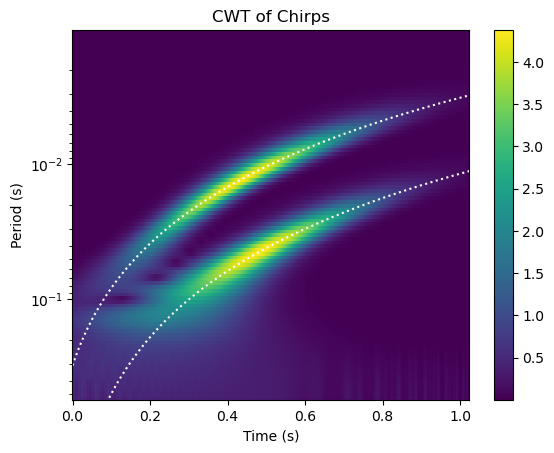

In [4]:
def freq_inst(t, t0, a):
    return a**2 * (3*t**2 + 4*t*t0 + t0**2)


def make_chirp(t, t0, a):
    frequency = (a * (t + t0)) ** 2
    chirp = np.sin(2*np.pi*frequency*t)
    frinst = freq_inst(t, t0, a)
    return chirp, frinst


chirp_signal, frequency1, frequency2 = chirps(time)

fig, ax1 = plt.subplots()
kw = dict(shading="flat")

pcm1 = ax1.pcolormesh(time1, chirp_period_scipy, np.abs(chirp_power_scipy), **kw)
ylim1 = ax1.get_ylim()
ax1.plot(time, 1/frequency1, "w:")
ax1.plot(time, 1/frequency2, "w:")
ax1.set_yscale("log")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Period (s)")
ax1.set_title("CWT of Chirps")
ax1.set_ylim(ylim1[::-1])
fig.colorbar(pcm1, ax=ax1)

*Huzzah!*

The cell below is an experiment setting frequencies and computing the widths/scales, rather than vice versa as done above.

/var/folders/s5/mzsl79_56tlczq9y98qqm33w0005sm/T/ipykernel_94151/3326490426.py:18: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  cwtmatr = signal.cwt(y_signal, wavelet, widths, w=w)


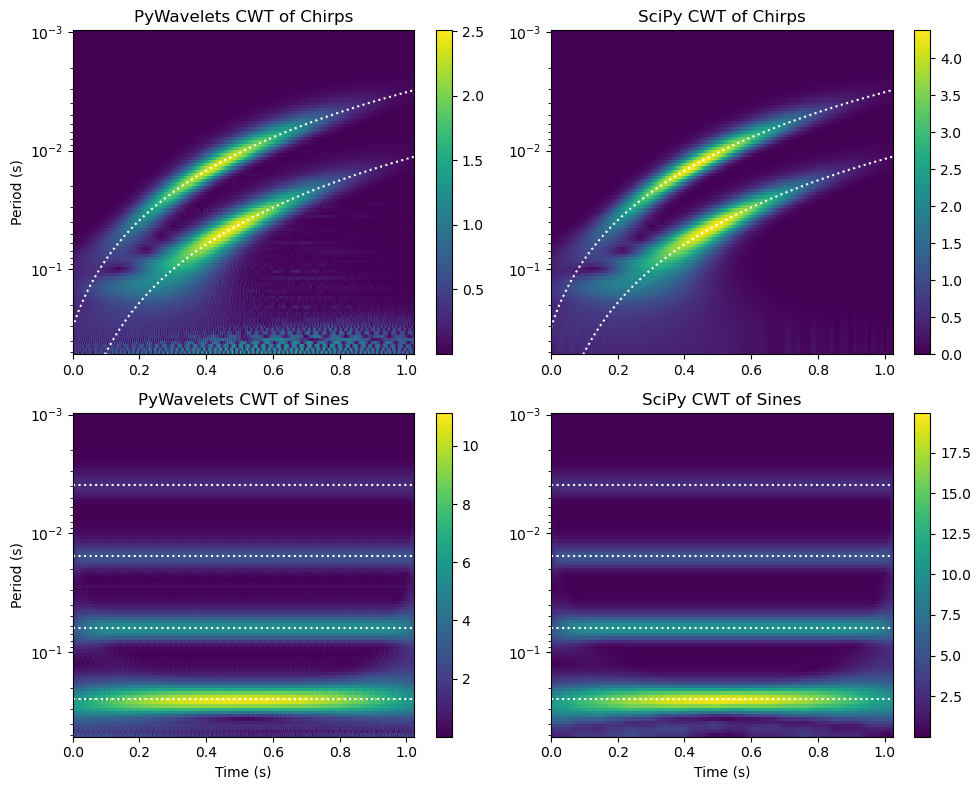

In [5]:
def cwt_pywt(time, y_signal, freqs, wavelet="cmor1.5-1.0"):
    sampling_period = np.diff(time).mean()
    widths = pywt.frequency2scale("cmor1.5-1.0", freqs*sampling_period)
    cwtmatr, freqs = pywt.cwt(y_signal, widths, wavelet, sampling_period=sampling_period)
    cwtmatr = np.abs(cwtmatr)

    # shift freqs to define the edges of the cells
    log_freqs = np.log10(freqs)
    delta_freq = np.diff(log_freqs).mean()
    log_freqs = np.append(log_freqs[0]-delta_freq/2, log_freqs+delta_freq/2)
    freqs = 10**log_freqs
    return cwtmatr, 1/freqs
    

def cwt_scipy(time, y_signal, freqs, w=6, wavelet=signal.morlet2):
    sampling_period = np.diff(time).mean()
    widths = w / (2*np.pi*sampling_period*freqs)
    cwtmatr = signal.cwt(y_signal, wavelet, widths, w=w)
    cwtmatr = np.abs(cwtmatr)#**2 / widths[:, np.newaxis]
    
    # shift freqs to define the edges of the cells
    log_freqs = np.log10(freqs)
    delta_freq = np.diff(log_freqs).mean()
    log_freqs = np.append(log_freqs[0]-delta_freq/2, log_freqs+delta_freq/2)
    freqs = 10**log_freqs
    return cwtmatr, 1/freqs



# logarithmic scale for scales, as suggested by Torrence & Compo:
freqs = np.geomspace(2, 1000, 100)

chirp_power_pywt, chirp_period_pywt = cwt_pywt(time, chirp_signal, freqs)
chirp_power_scipy, chirp_period_scipy = cwt_scipy(time, chirp_signal, freqs)
sines_power_pywt, sines_period_pywt = cwt_pywt(time, sine_signal, freqs)
sines_power_scipy, sines_period_scipy = cwt_scipy(time, sine_signal, freqs)

# shift time to define edges of the cells
time1 = np.append(time[0]-dt/2, time+dt/2)

# plot result using matplotlib's pcolormesh (image with annoted axes)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))
kw = dict(shading="flat")

pcm1 = ax1.pcolormesh(time1, chirp_period_pywt, chirp_power_pywt, **kw)
ylim1 = ax1.get_ylim()
ax1.plot(time, 1/frequency1, "w:")
ax1.plot(time, 1/frequency2, "w:")
ax1.set_yscale("log")
#ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Period (s)")
ax1.set_title("PyWavelets CWT of Chirps")
ax1.set_ylim(ylim1[::-1])
fig.colorbar(pcm1, ax=ax1)

pcm2 = ax2.pcolormesh(time1, chirp_period_scipy, chirp_power_scipy, **kw)
ylim2 = ax2.get_ylim()
ax2.plot(time, 1/frequency1, "w:")
ax2.plot(time, 1/frequency2, "w:")
ax2.set_yscale("log")
#ax2.set_xlabel("Time (s)")
#ax2.set_ylabel("Period (s)")
ax2.set_title("SciPy CWT of Chirps")
ax2.set_ylim(ylim2[::-1])
fig.colorbar(pcm2, ax=ax2)

pcm3 = ax3.pcolormesh(time1, sines_period_pywt, sines_power_pywt, **kw)
ylim3 = ax3.get_ylim()
ax3.hlines(periods, xmin=time[0], xmax=time[-1], color="w", linestyle=":")
ax3.set_yscale("log")
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("Period (s)")
ax3.set_title("PyWavelets CWT of Sines")
ax3.set_ylim(ylim3[::-1])
fig.colorbar(pcm3, ax=ax3)

pcm4 = ax4.pcolormesh(time1, sines_period_scipy, sines_power_scipy, **kw)
ylim4 = ax4.get_ylim()
ax4.hlines(periods, xmin=time[0], xmax=time[-1], color="w", linestyle=":")
ax4.set_yscale("log")
ax4.set_xlabel("Time (s)")
#ax4.set_ylabel("Period (s)")
ax4.set_title("SciPy CWT of Sines")
ax4.invert_yaxis()
ax4.set_ylim(ylim4[::-1])
fig.colorbar(pcm4, ax=ax4)

fig.tight_layout()

Still unexplained are the weird artifacts at long periods in `pywavelets`' transform for the chirps. There are artifacts in `scipy`'s as well, but they're less pronouced.

## Everything below here is just playing around

(-0.8, 1.0)

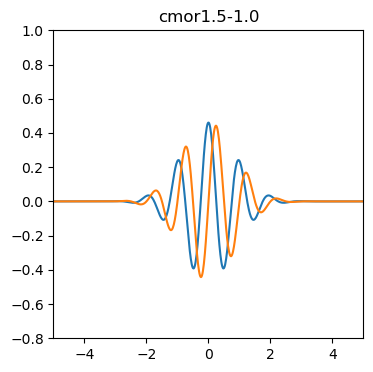

In [4]:
import matplotlib.pyplot as plt
import pywt
import numpy as np
wavelet = "cmor1.5-1.0"
fig, ax = plt.subplots(figsize=(4,4))
[psi, x] = pywt.ContinuousWavelet(wavelet).wavefun(10)
ax.plot(x, np.real(psi), label="real")
ax.plot(x, np.imag(psi), label="imag")
ax.set_title(wavelet)
ax.set_xlim([-5, 5])
ax.set_ylim([-0.8, 1])

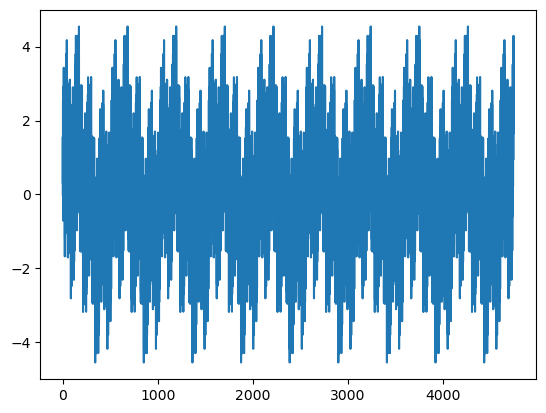

In [2]:
periods = 2, 8, 32, 128, 512
t0, tf = 0, 13*365.25
t = np.arange(t0, tf, 0.1)
y = np.sum([np.sin(2*np.pi*t/p) for p in periods], axis=0)
plt.plot(t, y);

/tmp/ipykernel_166/2780547923.py:25: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  power = signal.cwt(y, signal.morlet2, widths)


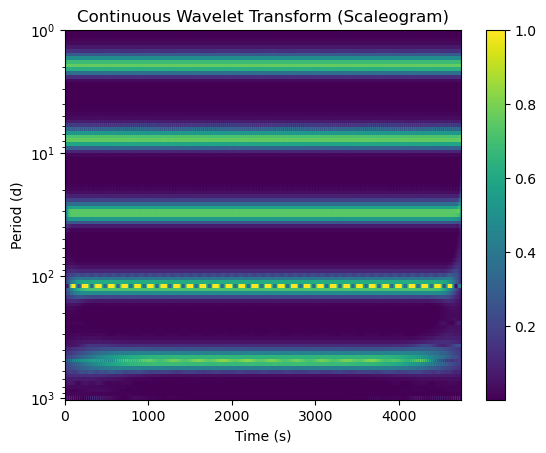

In [ ]:
# perform CWT
wavelet = "cmor1.5-1.0"
#wavelet = "cmor1.8-1.0"
#wavelet = "cmor0.5-2.0"
# logarithmic scale for scales, as suggested by Torrence & Compo:
freqs = np.geomspace(1/1024, 1, num=100)
widths = pywt.frequency2scale(wavelet, freqs/10)
sampling_period = np.diff(t).mean()
cwtmatr, freqs = pywt.cwt(y, widths, wavelet, sampling_period=sampling_period)
# absolute take absolute value of complex result
power1 = np.abs(cwtmatr[:-1, :-1])**2 / widths[:-1, np.newaxis] * np.sqrt(2*np.pi*1.5)

plt.close("all")
periods = 1/freqs
# plot result using matplotlib's pcolormesh (image with annoted axes)
fig, axs = plt.subplots()
pcm = axs.pcolormesh(t, periods, power1, vmax=1)
axs.set_yscale("log")
axs.set_xlabel("Time (s)")
axs.set_ylabel("Period (d)")
axs.set_title("Continuous Wavelet Transform (Scaleogram)")
axs.invert_yaxis()
fig.colorbar(pcm, ax=axs)

power = signal.cwt(y, signal.morlet2, widths)
power2 = np.abs(power[:-1, :-1])**2 / widths[:-1, np.newaxis]
fig, axs = plt.subplots()
pcm = axs.pcolormesh(t[:-1], periods[:-1], power2, vmax=1)
axs.set_yscale("log")
axs.set_xlabel("Time (s)")
axs.set_ylabel("Period (d)")
axs.set_title("Continuous Wavelet Transform (Scaleogram)")
axs.invert_yaxis()
fig.colorbar(pcm, ax=axs)

In [14]:
%pip install ssqueezepy

Note: you may need to restart the kernel to use updated packages.


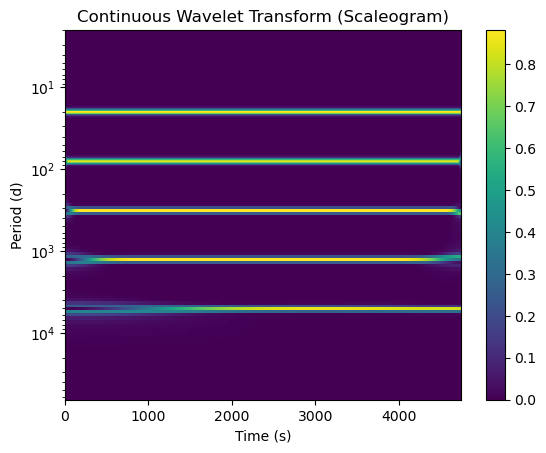

In [28]:
import ssqueezepy as sqpy
wx, scale = sqpy.cwt(y, wavelet="morlet", t=t)
p = 1/sqpy.experimental.scale_to_freq(scale, wavelet="morlet", N=len(t))

fig, axs = plt.subplots()
pcm = axs.pcolormesh(t, p, np.abs(wx)**2)
axs.set_yscale("log")
axs.set_xlabel("Time (s)")
axs.set_ylabel("Period (d)")
axs.set_title("Continuous Wavelet Transform (Scaleogram)")
axs.invert_yaxis()
fig.colorbar(pcm, ax=axs)

In [21]:
widths = np.geomspace(2, 4096, num=100)
time, period, power, phase = cwt(t, y, widths=widths)

plt.close("all")
fig, axs = plt.subplots()
pcm = axs.pcolormesh(t[:-1], period[:-1], power[:-1, :-1]**2 / widths[:-1, np.newaxis])
axs.set_yscale("log")
axs.set_xlabel("Time (s)")
axs.set_ylabel("Period (s)")
axs.set_title("Continuous Wavelet Transform (Scaleogram)")
axs.invert_yaxis()
fig.colorbar(pcm, ax=axs)

NameError: name 'cwt' is not defined